In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from datetime import datetime
import os

In [26]:
def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    
    if "closed" in ride_data.columns:
        if ride_data["closed"].dtype == bool:
            ride_data["closed"] = ride_data["closed"].astype(int)
        else:
            ride_data["closed"] = ride_data["closed"].astype(bool).astype(int)
    
    if ride_data['timestamp'].duplicated().any():
        print(f"Warning: Found {ride_data['timestamp'].duplicated().sum()} duplicate timestamps. Keeping first occurrence.")
        ride_data = ride_data[~ride_data['timestamp'].duplicated(keep='first')]
    
    try:
        ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    except Exception as e:
        print(f"Error during resampling: {e}")
        print("Using alternative approach to handle resampling...")
        
        ride_data['timestamp_rounded'] = ride_data['timestamp'].dt.floor('30min')
        numeric_cols = ride_data.select_dtypes(include=['number']).columns
        
        non_numeric_cols = [col for col in ride_data.columns 
                           if col not in numeric_cols and col != 'timestamp']

        agg_dict = {col: 'mean' for col in numeric_cols}
        for col in non_numeric_cols:
            agg_dict[col] = 'first'

        ride_data = ride_data.groupby('timestamp_rounded').agg(agg_dict).reset_index()
        ride_data.rename(columns={'timestamp_rounded': 'timestamp'}, inplace=True)

    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    return ride_data

def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    print("Sample of fully closed days:", fully_closed_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]

    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    print("Sample of zero wait time days:", zero_wait_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data

def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()

    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour

    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)

    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])

    def is_operating_hour(timestamp):
        date = timestamp.date()
        if date not in date_to_hours:
            return 0
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data

In [27]:
def create_binned_time_features(df):
    """Create more granular binned time features and other relevant features."""
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    
    # Create more granular time bins (1-hour bins instead of 3-hour bins)
    hour_bins = list(range(6, 24)) + [24]
    hour_bin_labels = [f"{h:02d}:00-{h+1:02d}:00" for h in range(6, 24)]
    
    df['hour_bin'] = pd.cut(
        df['hour'], 
        bins=hour_bins, 
        labels=hour_bin_labels, 
        include_lowest=True, 
        right=False
    )
    
    # Keep original time of day bins for comparison
    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 9),
        (df['hour'] >= 9) & (df['hour'] < 12),
        (df['hour'] >= 12) & (df['hour'] < 15),
        (df['hour'] >= 15) & (df['hour'] < 18),
        (df['hour'] >= 18) & (df['hour'] < 21),
        (df['hour'] >= 21) | (df['hour'] < 6)
    ]
    
    time_bins = [
        'early_morning',
        'late_morning',
        'early_afternoon',
        'late_afternoon',
        'early_evening',
        'night'
    ]
    
    df['time_of_day_bin'] = np.select(conditions, time_bins, default='other')
    
    # Add day-specific features
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['day_of_month'] = df['timestamp'].dt.day
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week
    
    # More detailed month and season information
    df['month'] = df['timestamp'].dt.month
    
    # Create month pairs to better capture seasonal effects
    df['month_pair'] = ((df['month'] - 1) // 2) + 1
    
    conditions = [
        (df['month'] >= 3) & (df['month'] <= 5),
        (df['month'] >= 6) & (df['month'] <= 8),
        (df['month'] >= 9) & (df['month'] <= 11),
        (df['month'] == 12) | (df['month'] <= 2)
    ]
    
    seasons = ['spring', 'summer', 'fall', 'winter']
    df['season'] = np.select(conditions, seasons, default='unknown')
    
    # Create interaction features for time and day
    df['weekend_hour'] = df['hour'] * df['is_weekend']
    
    # Process holiday columns
    holiday_cols = ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
    existing_holiday_cols = [col for col in holiday_cols if col in df.columns]
    
    if existing_holiday_cols:
        df['is_any_holiday'] = df[existing_holiday_cols].max(axis=1)
        df['holiday_weekend'] = df['is_any_holiday'] * df['is_weekend']
    else:
        df['is_any_holiday'] = 0
        df['holiday_weekend'] = 0

    # More detailed temperature binning
    if 'temperature' in df.columns:
        bins = [0, 5, 10, 15, 20, 25, 30, 100]
        labels = ['very_cold', 'cold', 'cool', 'mild', 'warm', 'hot', 'very_hot']
        df['temp_bin'] = pd.cut(df['temperature'], bins=bins, labels=labels)
    
    # Rain intensity categorization
    if 'rain' in df.columns:
        df['has_rain'] = (df['rain'] > 0).astype(int)
        bins = [0, 0.001, 1, 2.5, 5, 100]  
        labels = ['none', 'light', 'moderate', 'heavy', 'extreme']
        df['rain_intensity'] = pd.cut(df['rain'], bins=bins, labels=labels)
    
    return df

In [28]:
def prepare_features_for_linear_model(df):
    """Prepare enhanced features for the linear model."""
    # We'll now use hour_bin instead of time_of_day_bin for more granularity
    categorical_features = ['hour_bin', 'season', 'day_of_week']

    # Add more features for better predictive power
    numerical_features = [
        'is_weekend', 
        'is_any_holiday', 
        'holiday_weekend', 
        'week_of_year',
        'day_of_month'
    ]

    # Add interaction and contextual features
    if 'weekend_hour' in df.columns:
        numerical_features.append('weekend_hour')
    
    # Use more detailed weather binning if available
    if 'temp_bin' in df.columns:
        categorical_features.append('temp_bin')
    if 'rain_intensity' in df.columns:
        categorical_features.append('rain_intensity')
    
    # Include raw weather data if available
    if 'temperature' in df.columns:
        numerical_features.append('temperature')
    if 'rain' in df.columns:
        numerical_features.append('rain')
    if 'wind' in df.columns:
        numerical_features.append('wind')
    if 'has_rain' in df.columns:
        numerical_features.append('has_rain')
    if 'closed' in df.columns:
        numerical_features.append('closed')

    # Add historical wait times as features if available
    if 'previous_day_wait' in df.columns:
        numerical_features.append('previous_day_wait')
    if 'previous_week_wait' in df.columns:
        numerical_features.append('previous_week_wait')

    feature_df = df[categorical_features + numerical_features].copy()

    # Handle missing values
    null_counts = feature_df.isnull().sum()
    if null_counts.sum() > 0:
        print("Warning: Missing values detected in features:")
        print(null_counts[null_counts > 0])

        for col in numerical_features:
            if col in feature_df.columns and feature_df[col].isnull().sum() > 0:
                feature_df[col] = feature_df[col].fillna(feature_df[col].median())

        for col in categorical_features:
            if col in feature_df.columns and feature_df[col].isnull().sum() > 0:
                feature_df[col] = feature_df[col].fillna(feature_df[col].mode()[0])
    
    return feature_df, categorical_features, numerical_features

In [29]:
def build_and_train_linear_model(X_train, y_train, categorical_features, numerical_features, polynomial_degree=2):
    """Build and train a linear regression model with preprocessing pipeline and polynomial features."""
    from sklearn.preprocessing import PolynomialFeatures
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # For numerical features, we'll add polynomial features to capture non-linear relationships
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=polynomial_degree, include_bias=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )

    # Let's also add regularization to prevent overfitting
    from sklearn.linear_model import Ridge
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=1.0))  # Ridge regression with regularization
    ])

    model.fit(X_train, y_train)
    
    return model

In [30]:
def evaluate_model(model, X_test, y_test, feature_names=None):
    """Evaluate the linear regression model and print coefficients."""
    # Get raw predictions
    y_pred_raw = model.predict(X_test)
    
    # Clip predictions at 0 to prevent negative wait times
    y_pred = np.maximum(y_pred_raw, 0)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
    print(f"R² Score: {r2:.4f}")

    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    if feature_names is not None:
        print("\nFeature Importance (Coefficients):")
        try:
            linear_model = model.named_steps['regressor']
            preprocessor = model.named_steps['preprocessor']

            if hasattr(preprocessor, 'get_feature_names_out'):
                feature_names = preprocessor.get_feature_names_out()

            coefficients = pd.DataFrame(
                linear_model.coef_,
                index=feature_names,
                columns=['Coefficient']
            ).sort_values('Coefficient', ascending=False)

            print("\nTop 10 Positive Coefficients:")
            print(coefficients.head(10))
            
            print("\nTop 10 Negative Coefficients:")
            print(coefficients.tail(10))
        except Exception as e:
            print(f"Could not print coefficients: {e}")
    
    return mae, rmse, r2, mape, y_pred

In [31]:
def visualize_results(y_test, y_pred, ride_data_test):
    """Visualize the prediction results."""
    # Make sure predictions are non-negative (this is redundant if evaluate_model already did this)
    y_pred = np.maximum(y_pred, 0)
    
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_pred - y_test,
        'Timestamp': ride_data_test['timestamp'].values
    })

    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    axes[0].scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    axes[0].plot([0, max_val], [0, max_val], 'r--')
    axes[0].set_xlabel('Actual Wait Time (minutes)')
    axes[0].set_ylabel('Predicted Wait Time (minutes)')
    axes[0].set_title('Actual vs Predicted Wait Times')
    axes[0].grid(True, linestyle=':')

    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    results_df = results_df.sort_values('Timestamp')
    axes[1].plot(results_df['Timestamp'], results_df['Actual'], label='Actual', alpha=0.7)
    axes[1].plot(results_df['Timestamp'], results_df['Predicted'], label='Predicted', alpha=0.7)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Wait Time (minutes)')
    axes[1].set_title('Actual vs Predicted Wait Times Over Time')
    axes[1].grid(True, linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    if 'hour' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['hour'] = ride_data_test['timestamp'].dt.hour

    if 'hour' in ride_data_test.columns:
        results_df['hour'] = ride_data_test['hour'].values

        hourly_errors = results_df.groupby('hour')['Error'].mean()

        if not hourly_errors.empty:
            plt.figure(figsize=(12, 6))
            hourly_errors.plot(kind='bar')
            plt.xlabel('Hour of Day')
            plt.ylabel('Mean Error (minutes)')
            plt.title('Mean Prediction Error by Hour of Day')
            plt.grid(True, linestyle=':')
            plt.tight_layout()
            plt.show()
    
    if 'day_of_week' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['day_of_week'] = ride_data_test['timestamp'].dt.dayofweek

    if 'day_of_week' in ride_data_test.columns:
        results_df['day'] = ride_data_test['day_of_week'].values
        daily_errors = results_df.groupby('day')['Error'].mean()

        if not daily_errors.empty:
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            plt.figure(figsize=(12, 6))
            daily_errors.plot(kind='bar')
            plt.xlabel('Day of Week')
            plt.ylabel('Mean Error (minutes)')
            plt.title('Mean Prediction Error by Day of Week')
            plt.xticks(range(len(days)), days)
            plt.grid(True, linestyle=':')
            plt.tight_layout()
            plt.show()

CREATING CONSOLIDATED PARK-WIDE ATTENDANCE INDEX
Loading full dataset for park-wide attendance calculation...
Dataset contains 35 rides
Found 1929048 NaN values in wait_time column out of 14196903 rows.
NaN percentage: 13.59%
Using 12267855 rows with valid wait times for attendance calculation


C:\Users\Nevin\AppData\Local\Temp\ipykernel_260\2947757301.py:361: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_filtered['date'] = full_data_filtered['timestamp'].dt.date


Calculating park-wide attendance metrics...


C:\Users\Nevin\AppData\Local\Temp\ipykernel_260\2947757301.py:386: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_filtered['hour'] = full_data_filtered['timestamp'].dt.hour


Top 5 most popular rides (by average wait time):
1. eurosat  cancan coaster: 13.3 minutes
2. arthur: 13.0 minutes
3. blue fire megacoaster: 13.0 minutes
4. silver star: 10.7 minutes
5. matterhornblitz: 10.5 minutes
Calibrating attendance index using 7 known busiest days:
  - 2023-05-19
  - 2022-05-26
  - 2022-05-27
  - 2022-08-16
  - 2023-07-31
  - 2019-05-31
  - 2019-08-14

Reference values from busiest days:
- Total wait time: 90995.0 minutes
- Average wait time: 19.7 minutes
- Median wait time: 10.0 minutes
Successfully created calibrated attendance index


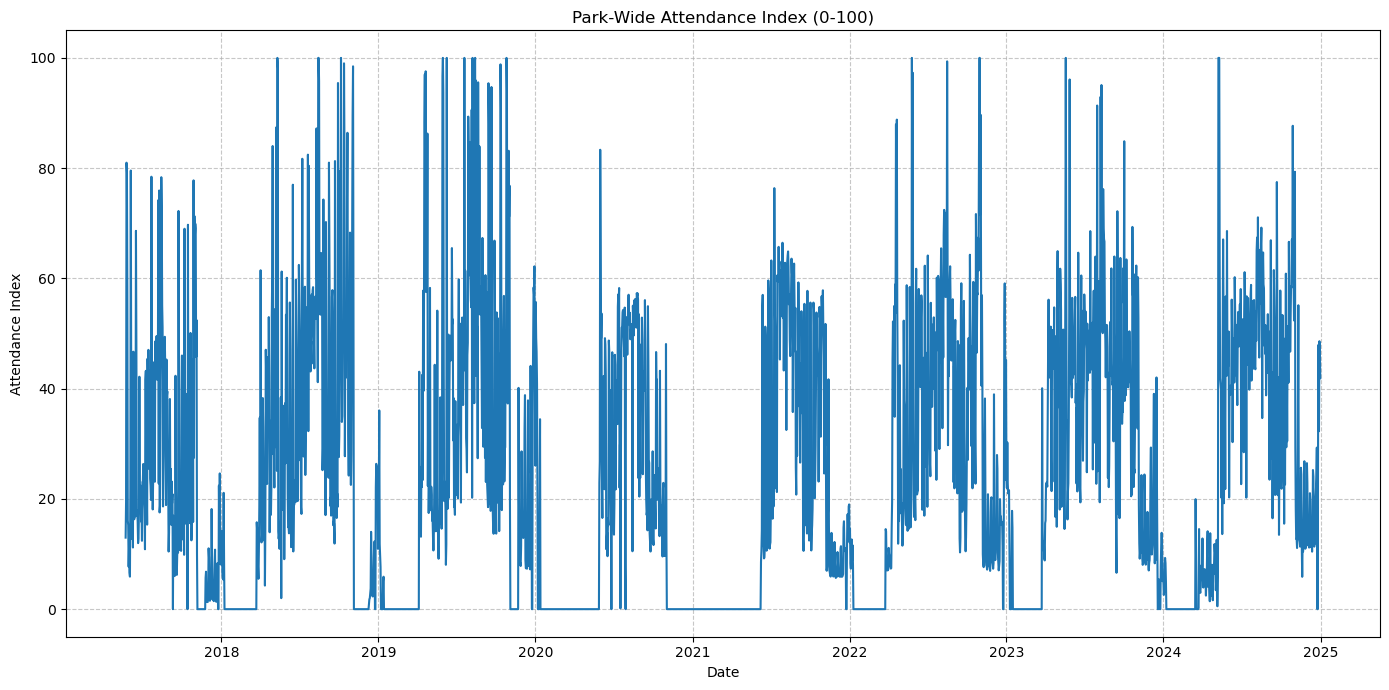

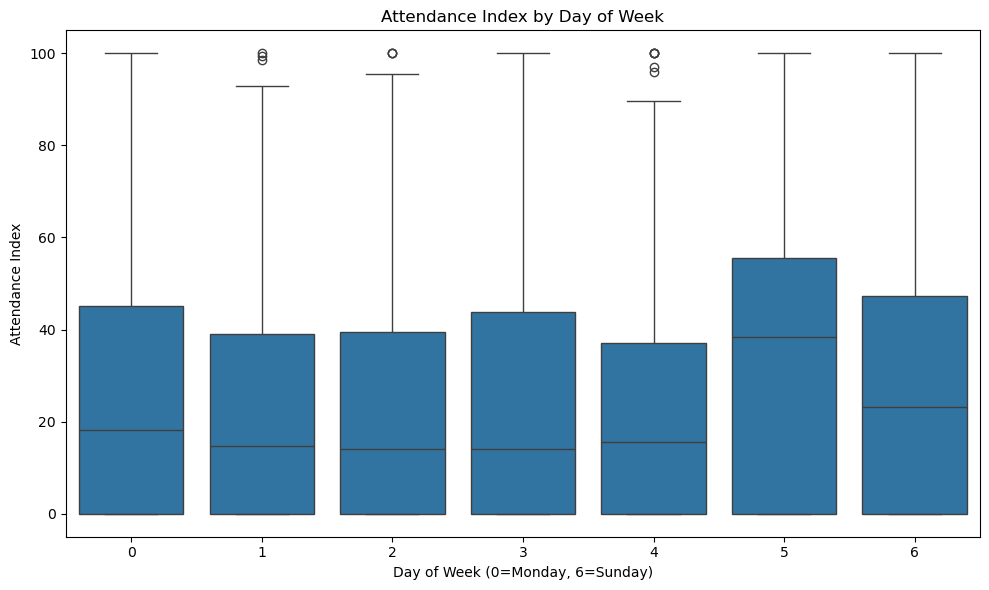

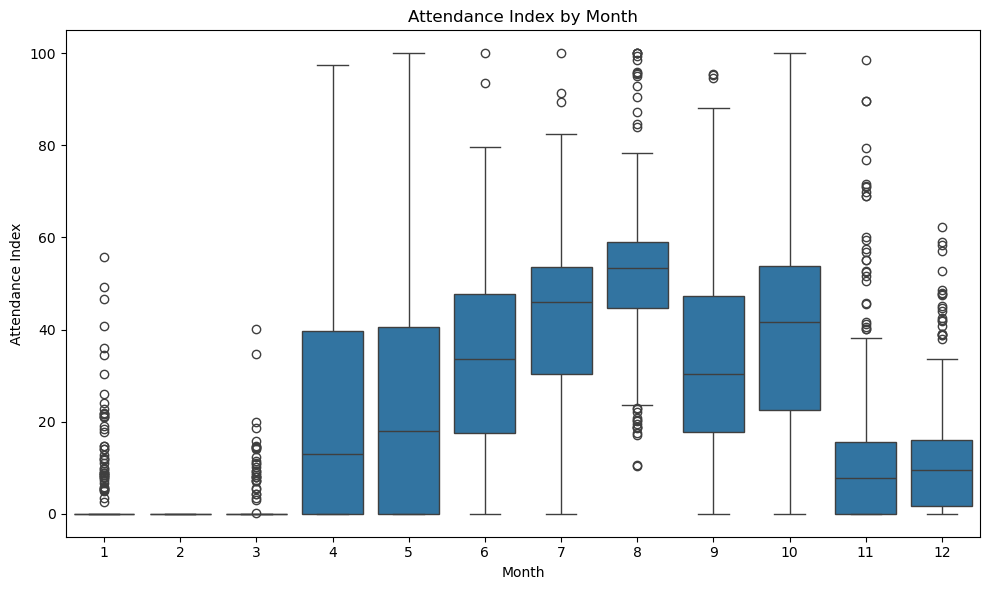

Joining attendance data back to ride data...

ANALYZING RIDE: SILVER STAR
BASELINE MODEL (WITHOUT ATTENDANCE FEATURES)
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 82
Sample of zero wait time days: Index([2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30,
       2017-12-01, 2017-12-02, 2017-12-03, 2017-12-04],
      dtype='object', name='timestamp')
temp_bin            262
rain_intensity    15124
temperature         143
rain               4297
wind                368
dtype: int64
temp_bin            23
rain_intensity    3202
temperature         10
rain                10
wind                10
dtype: int64
Training data: 21421 rows
Test data: 4018 rows
Mean Absolute Error (MAE): 8.47 minutes
Root Mean Squared Error (RMSE): 10.96 minutes
R² S

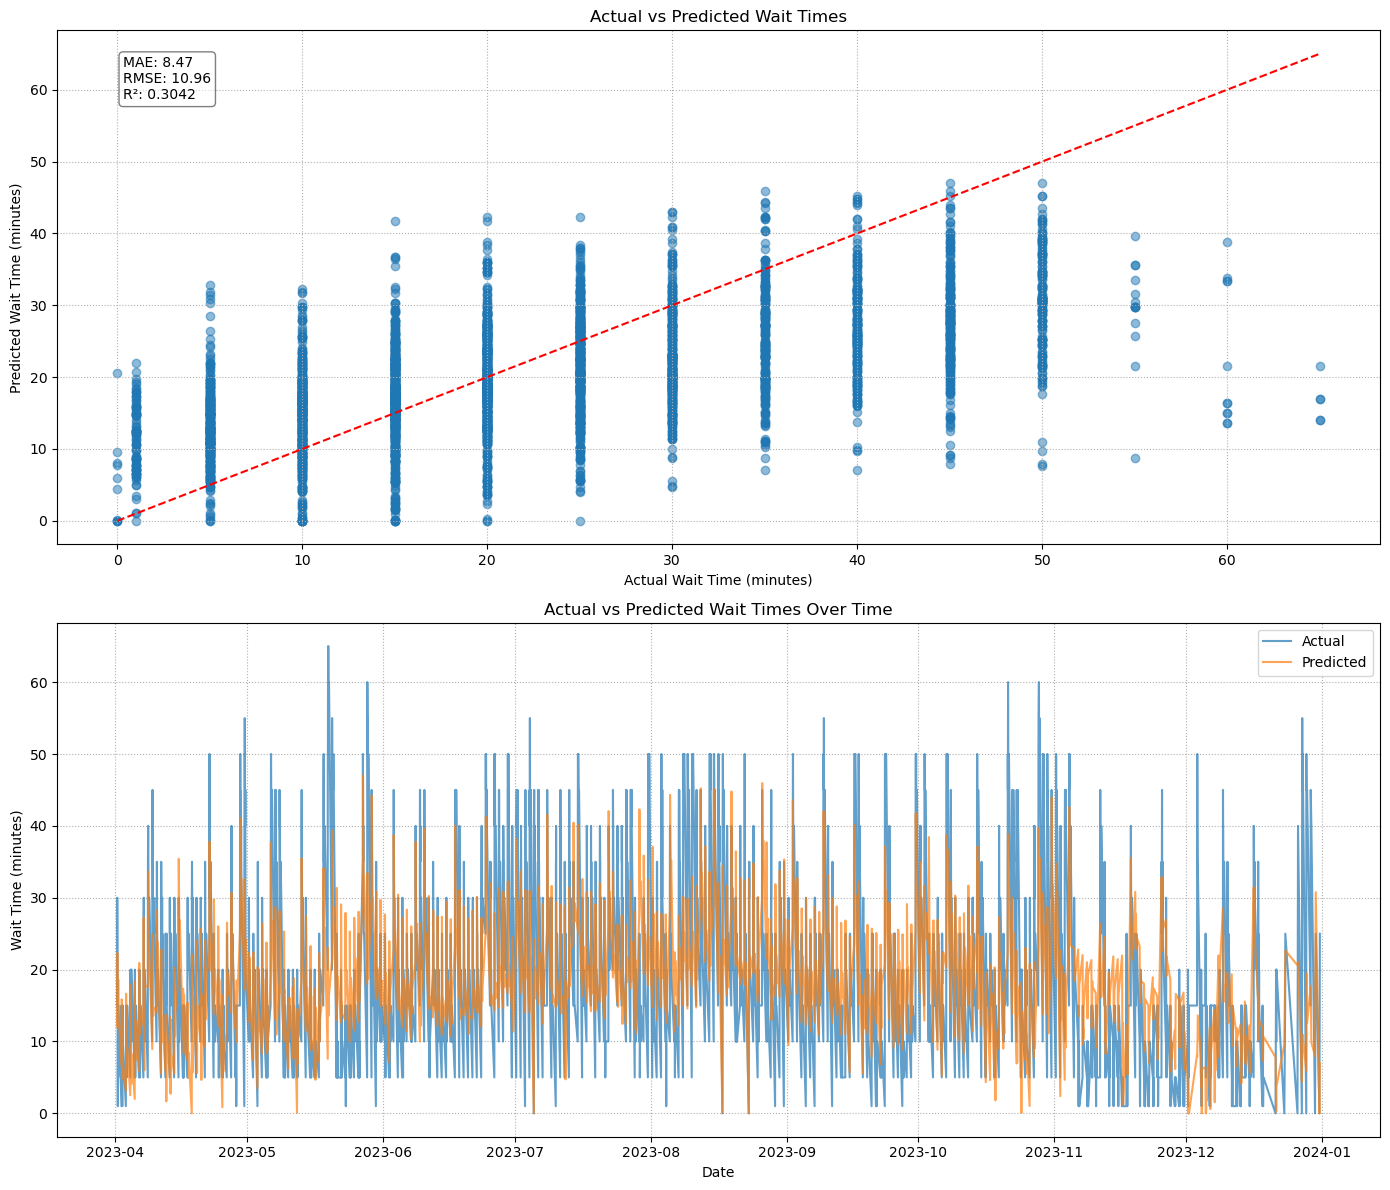

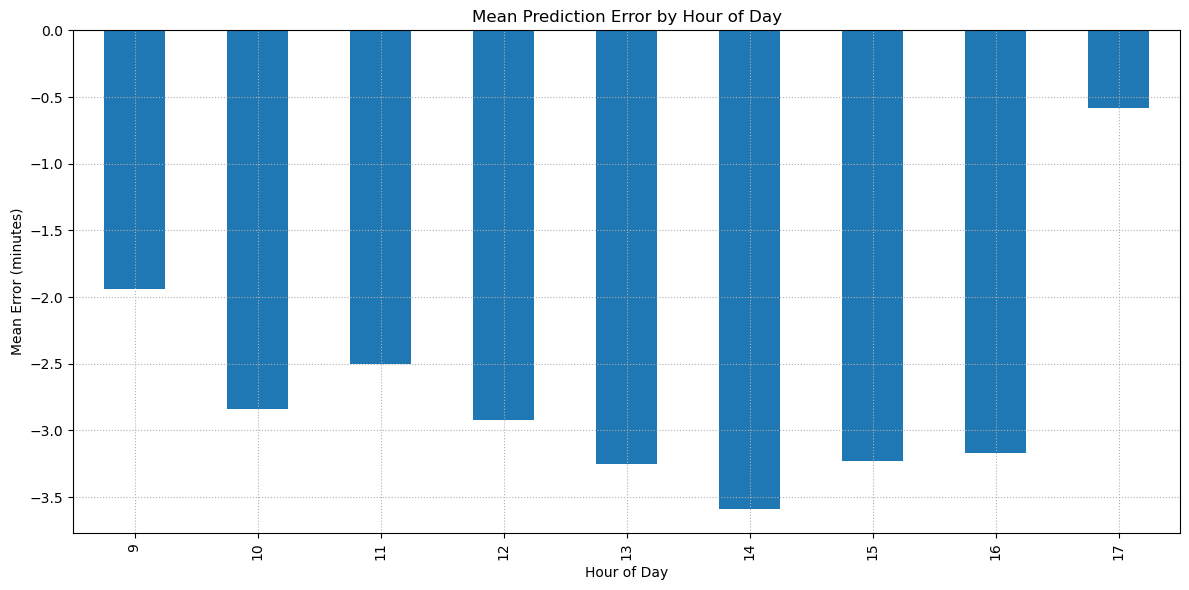

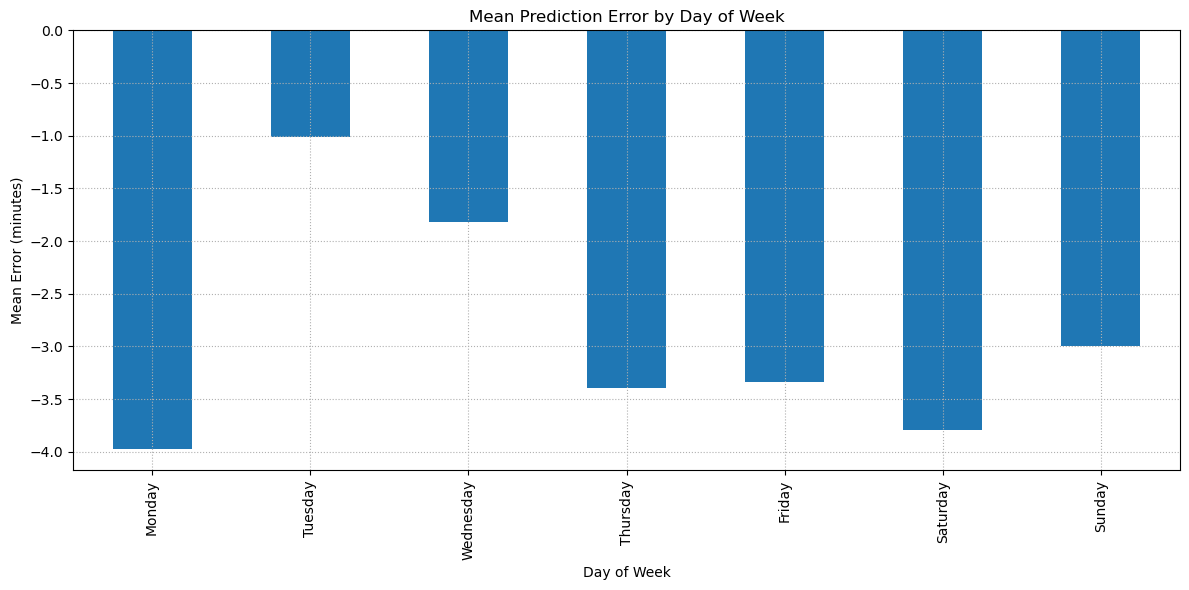


ENHANCED MODEL (WITH SHARED ATTENDANCE FEATURES)
Number of fully closed days: 833
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 59
Sample of zero wait time days: Index([2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30,
       2017-12-01, 2017-12-02, 2017-12-03, 2017-12-04],
      dtype='object', name='timestamp')
Training data with attendance: 121043 rows
Test data with attendance: 25644 rows
Mean Absolute Error (MAE): 5.02 minutes
Root Mean Squared Error (RMSE): 6.82 minutes
R² Score: 0.7222
Mean Absolute Percentage Error (MAPE): 38.44%
Visualizing enhanced model results...


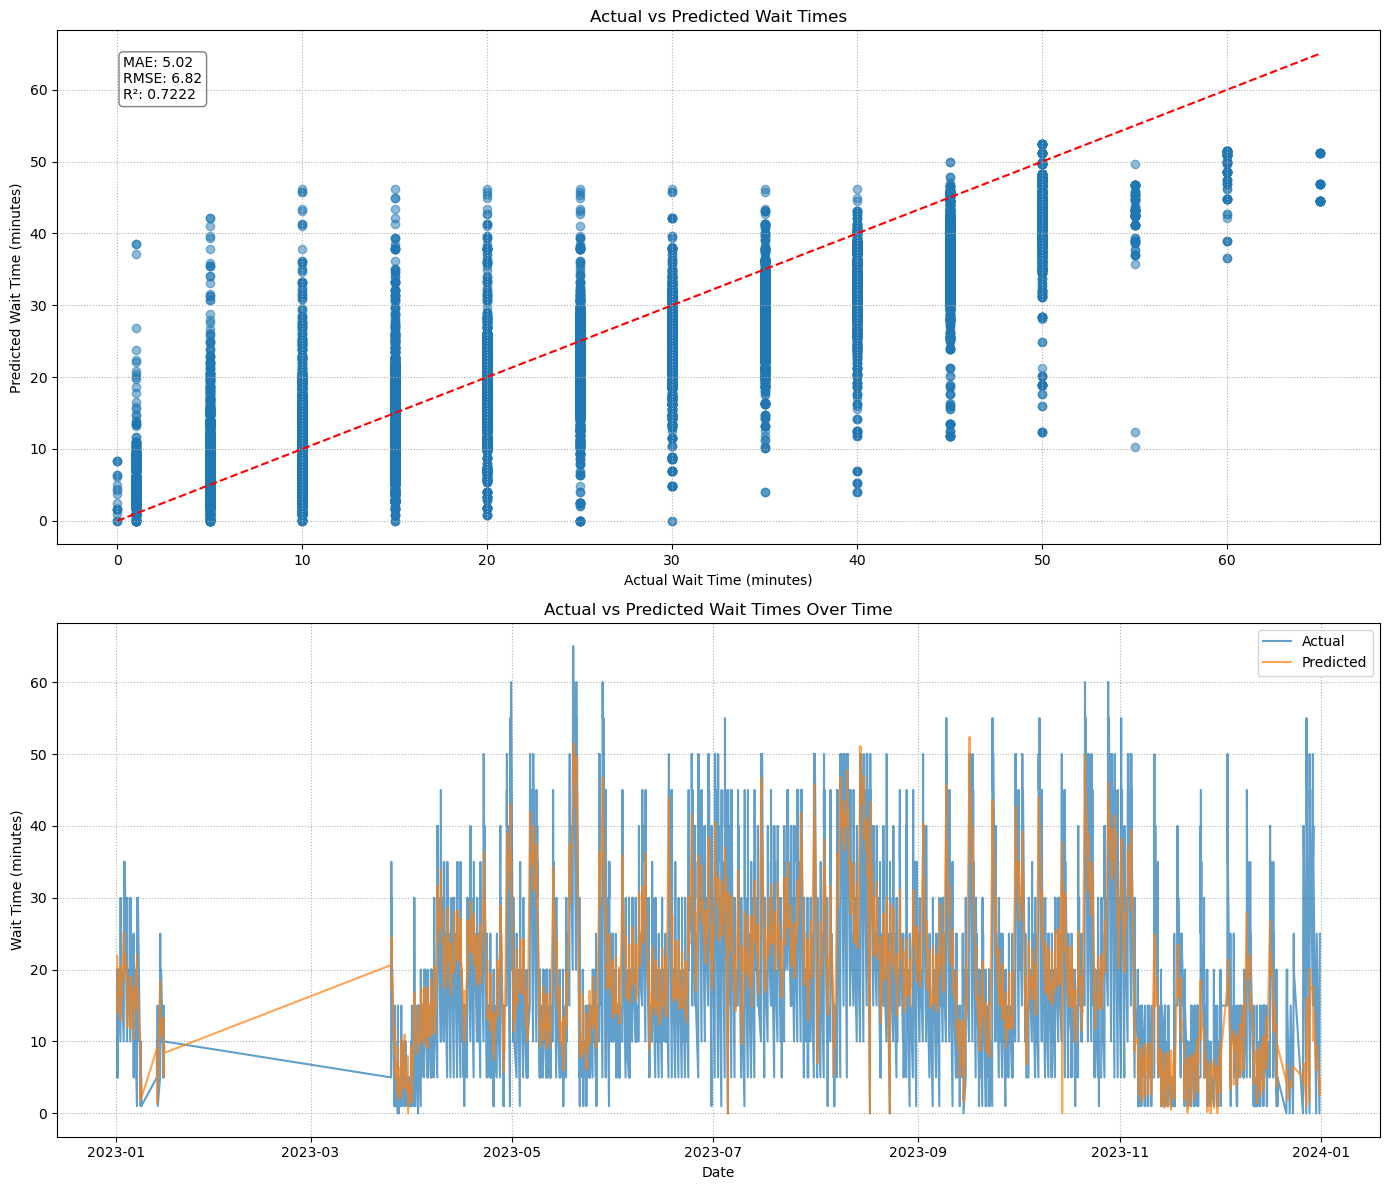

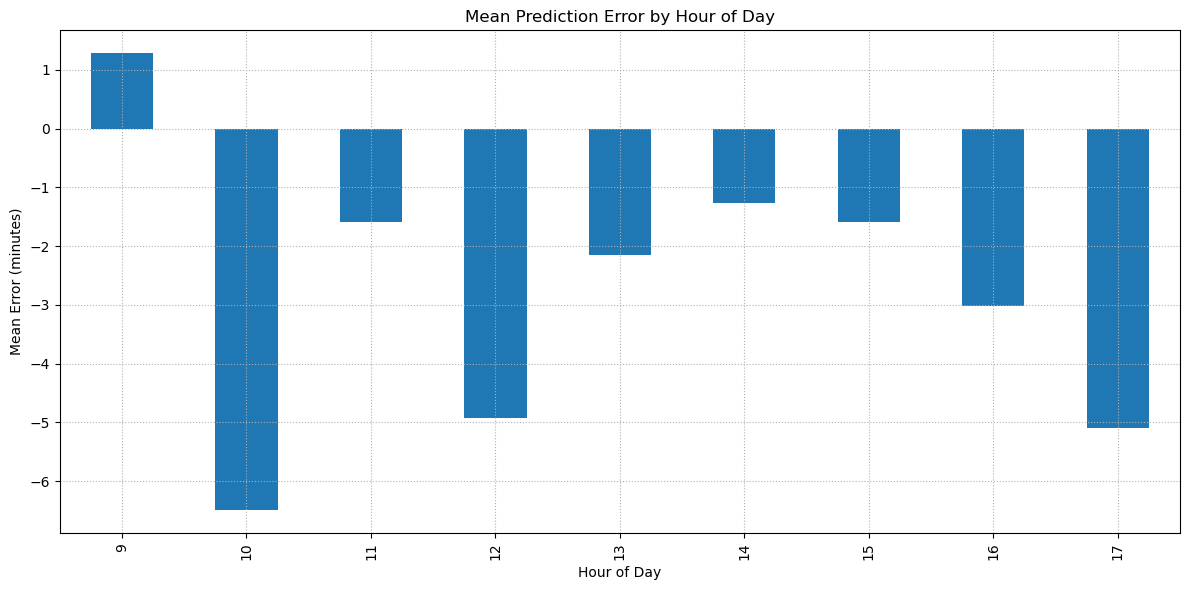

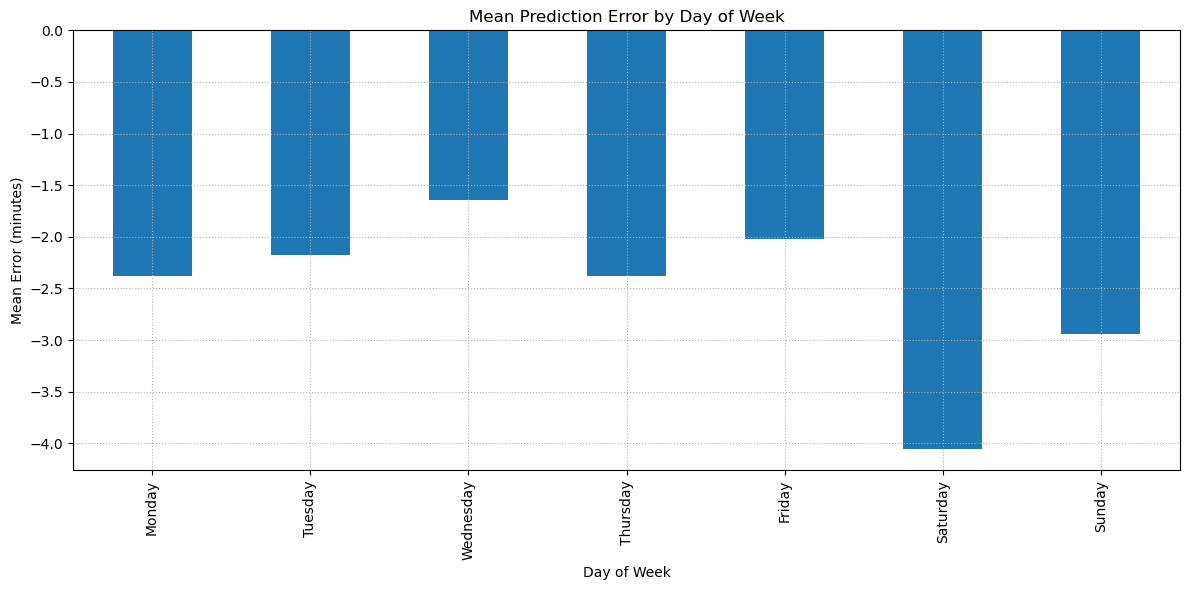


MODEL COMPARISON FOR silver star
       Baseline  With Attendance
MAE    8.467528         5.016633
RMSE  10.964675         6.821264
R²     0.304226         0.722227
MAPE  71.053506        38.442364

Improvement with Attendance Features:
  Metric   Baseline  With Attendance  Difference  Improvement %
0    MAE   8.467528         5.016633    3.450895      40.754459
1   RMSE  10.964675         6.821264    4.143412      37.788732
2     R²   0.304226         0.722227    0.418001     137.398390

ANALYZING RIDE: POSEIDON
BASELINE MODEL (WITHOUT ATTENDANCE FEATURES)
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 593
Sample of zero wait time days: Index([2017-06-06, 2017-08-31, 2017-09-12, 2017-09-13, 2017-09-14, 2017-09-19,
       2017-09-20, 2017-10-06, 2017-10-08, 2017

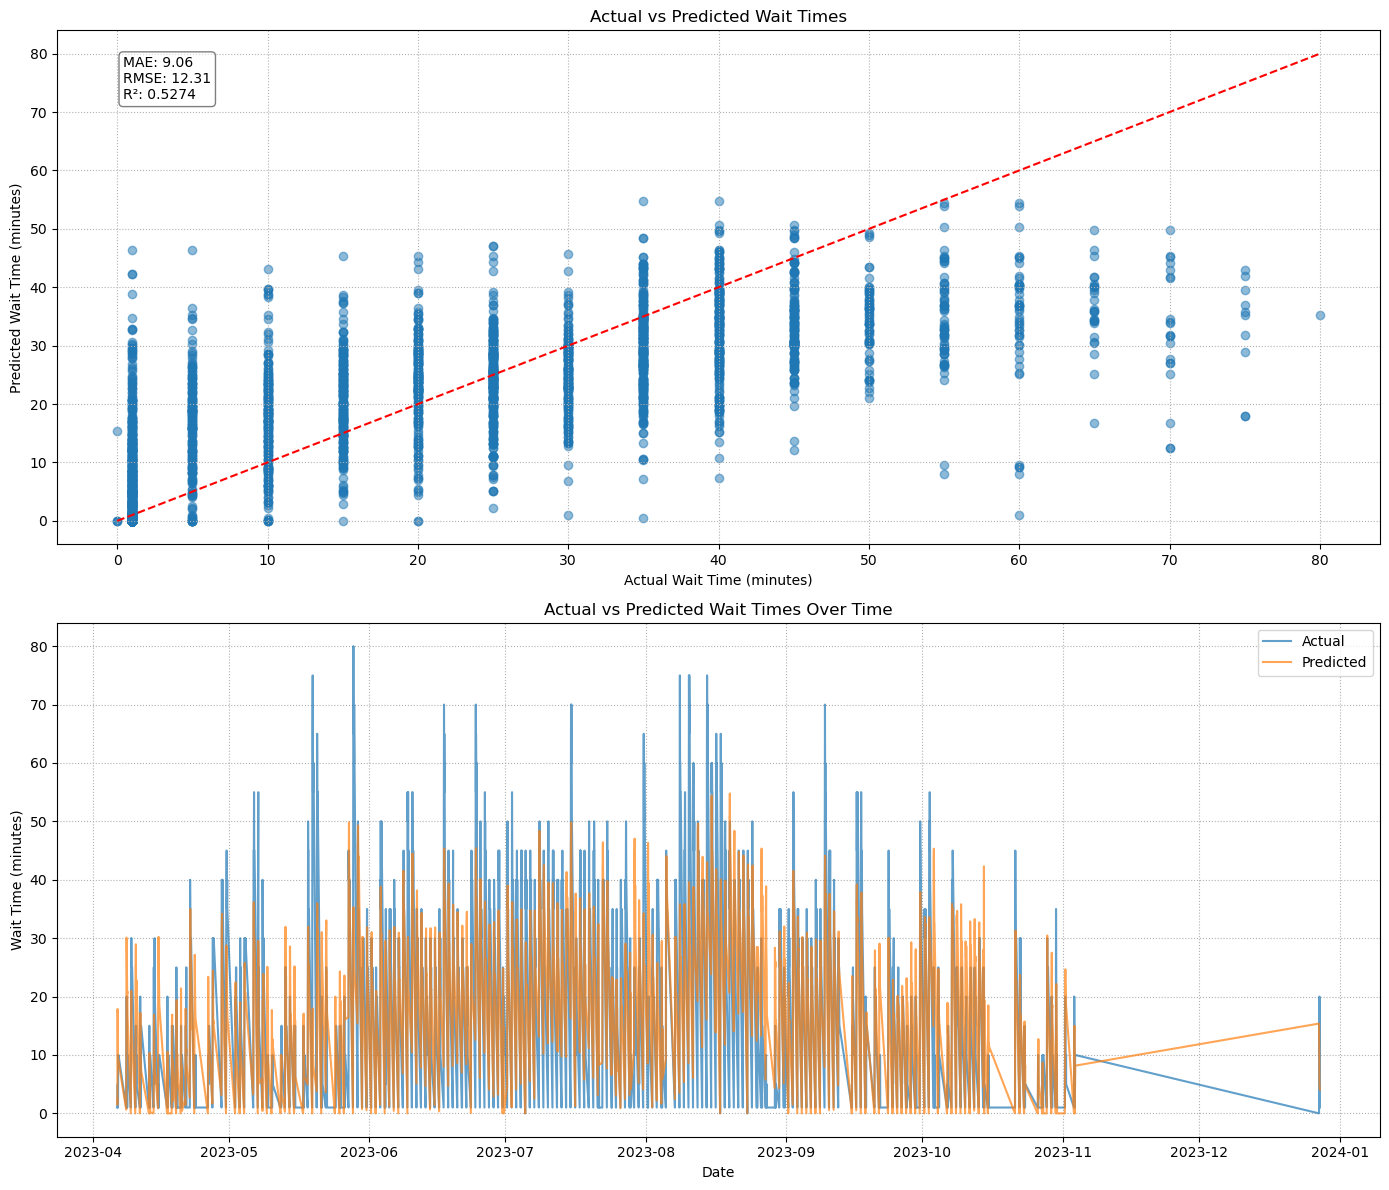

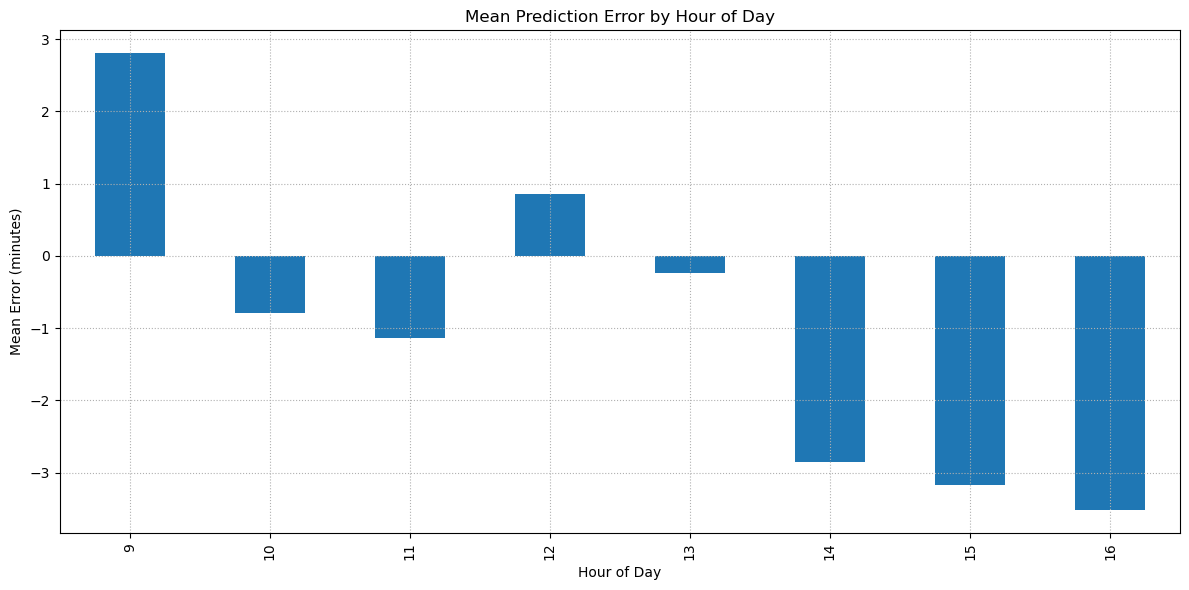

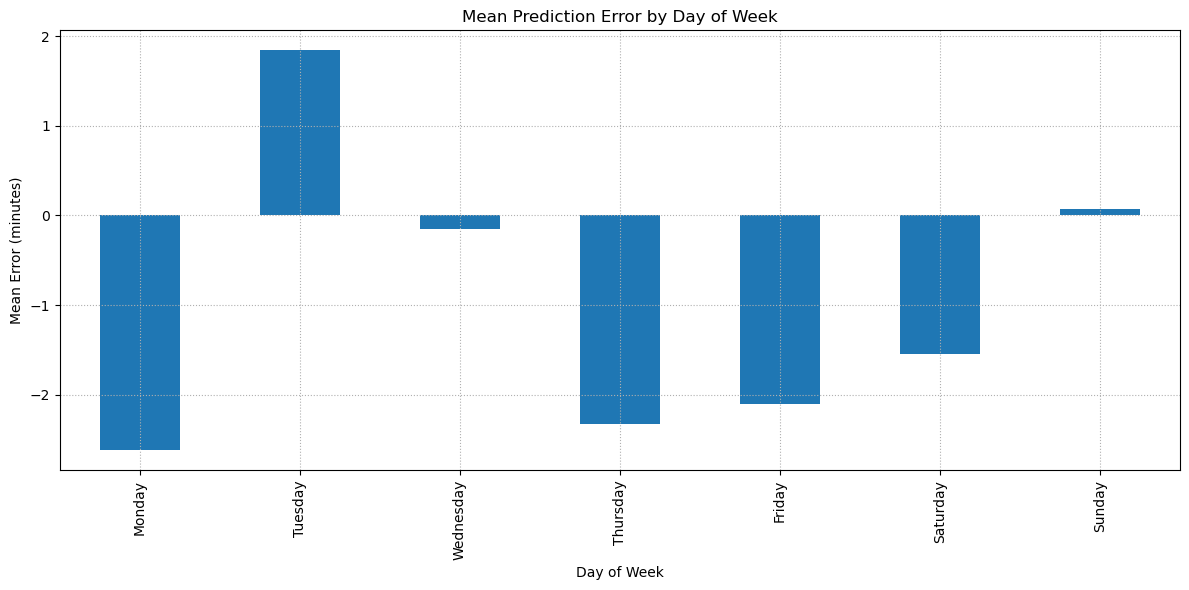


ENHANCED MODEL (WITH SHARED ATTENDANCE FEATURES)
Number of fully closed days: 833
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 544
Sample of zero wait time days: Index([2017-09-13, 2017-09-14, 2017-09-19, 2017-10-06, 2017-10-23, 2017-11-05,
       2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28],
      dtype='object', name='timestamp')
Training data with attendance: 102665 rows
Test data with attendance: 18688 rows
Mean Absolute Error (MAE): 6.71 minutes
Root Mean Squared Error (RMSE): 8.59 minutes
R² Score: 0.7711
Mean Absolute Percentage Error (MAPE): 189.97%
Visualizing enhanced model results...


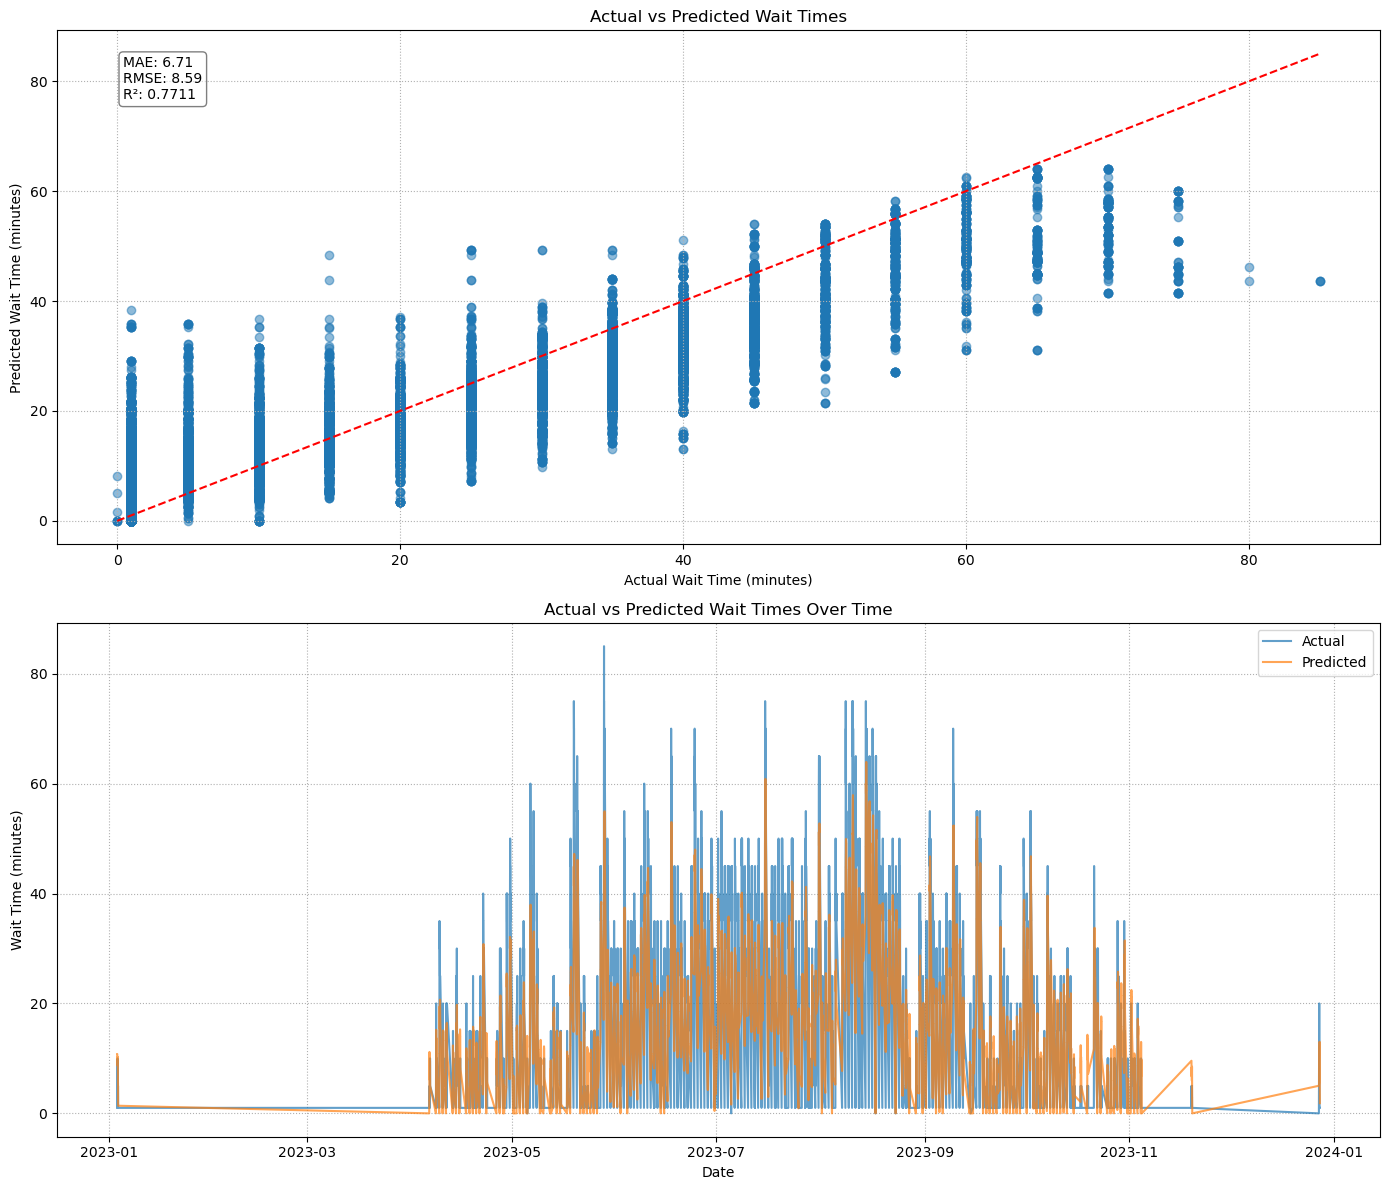

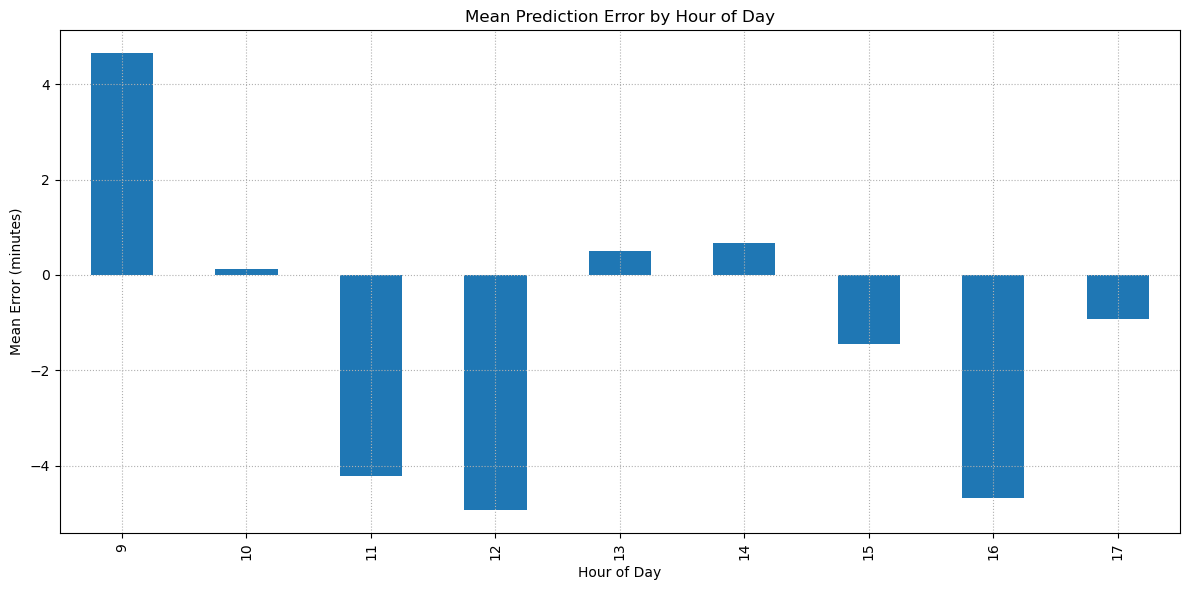

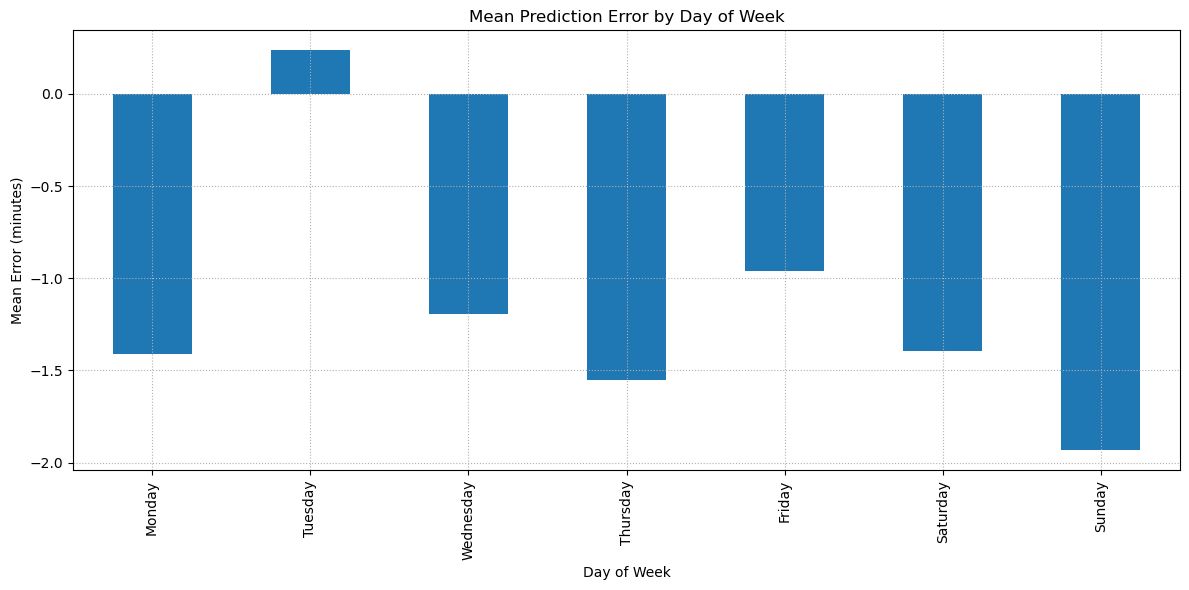


MODEL COMPARISON FOR poseidon
        Baseline  With Attendance
MAE     9.056617         6.707946
RMSE   12.308732         8.593284
R²      0.527360         0.771131
MAPE  187.106505       189.974037

Improvement with Attendance Features:
  Metric   Baseline  With Attendance  Difference  Improvement %
0    MAE   9.056617         6.707946    2.348672      25.933211
1   RMSE  12.308732         8.593284    3.715448      30.185466
2     R²   0.527360         0.771131    0.243771      46.224709

COMPARATIVE SUMMARY ACROSS RIDES
          Ride  Baseline MAE  With Attendance MAE  Improvement %
0  silver star      8.467528             5.016633      40.754459
1     poseidon      9.056617             6.707946      25.933211
Error in analysis: 'Pandas' object has no attribute 'Baseline_MAE'


Traceback (most recent call last):
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_260\2947757301.py", line 570, in <module>
    ride_results, daily_attendance = compare_ride_models_with_shared_attendance(
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Nevin\AppData\Local\Temp\ipykernel_260\2947757301.py", line 311, in compare_ride_models_with_shared_attendance
    plt.text(i, max(row.Baseline_MAE, row.With_Attendance_MAE) + 0.5,
                   ^^^^^^^^^^^^^^^^
AttributeError: 'Pandas' object has no attribute 'Baseline_MAE'


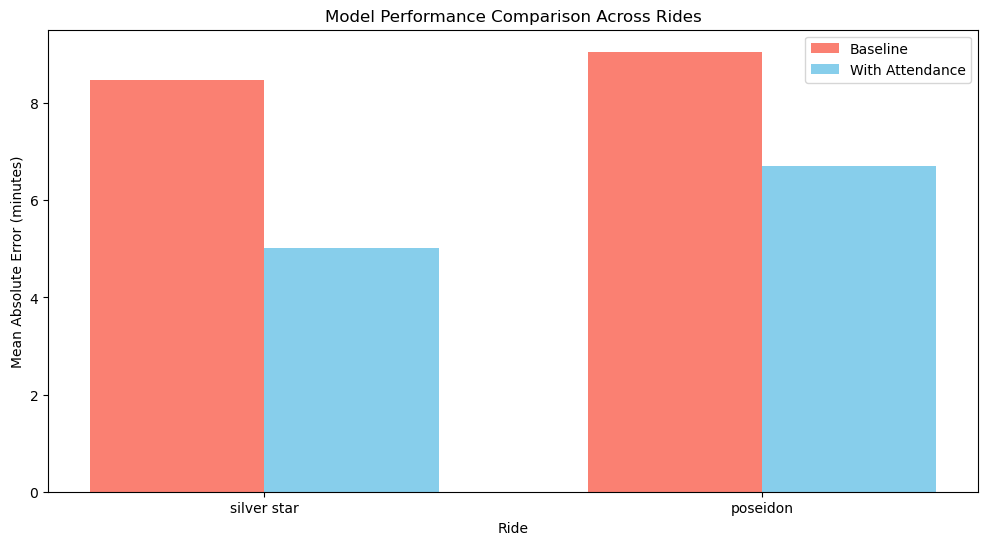

In [32]:
def compare_ride_models_with_shared_attendance(ride_names, data_path, busiest_days=None, test_year=2023):
    """
    Compare models with and without shared attendance features for multiple rides.
    
    Parameters:
    -----------
    ride_names : list of str
        Names of the rides to model
    data_path : str
        Path to the parquet file
    busiest_days : list of str, optional
        List of dates (YYYY-MM-DD format) known to be the busiest days
    test_year : int
        Year to use for testing
    """
    # First create consolidated attendance proxy
    print("=" * 60)
    print("CREATING CONSOLIDATED PARK-WIDE ATTENDANCE INDEX")
    print("=" * 60)
    
    full_data_with_attendance, daily_attendance = create_consolidated_attendance_proxy(
        data_path, 
        busiest_days=busiest_days,
        test_year=test_year
    )
    
    # Store results for all rides
    ride_results = {}
    
    # Process each ridebuild_and_train_linear_model
    for ride_name in ride_names:
        print("\n" + "=" * 60)
        print(f"ANALYZING RIDE: {ride_name.upper()}")
        print("=" * 60)
        
        # Train baseline model
        print("=" * 50)
        print("BASELINE MODEL (WITHOUT ATTENDANCE FEATURES)")
        print("=" * 50)
        
        # Load data directly for the baseline model
        baseline_ride_df = load_ride_data(data_path, ride_name)
        baseline_ride_df = remove_closed_and_zero_wait_days(baseline_ride_df)
        baseline_ride_df = filter_to_operating_hours(baseline_ride_df)
        baseline_ride_df = baseline_ride_df.dropna(subset=['wait_time'])
        baseline_ride_df = create_binned_time_features(baseline_ride_df)
        
        # Split into train and test
        baseline_train = baseline_ride_df[baseline_ride_df['timestamp'].dt.year < test_year]
        baseline_test = baseline_ride_df[baseline_ride_df['timestamp'].dt.year == test_year]
        
        # Prepare features
        baseline_X_train, baseline_cat_feat, baseline_num_feat = prepare_features_for_linear_model(baseline_train)
        baseline_X_test, _, _ = prepare_features_for_linear_model(baseline_test)
        
        baseline_y_train = baseline_train['wait_time'].values
        baseline_y_test = baseline_test['wait_time'].values
        
        print(f"Training data: {len(baseline_X_train)} rows")
        print(f"Test data: {len(baseline_X_test)} rows")
        
        # Train baseline model
        baseline_model = build_and_train_linear_model(baseline_X_train, baseline_y_train, baseline_cat_feat, baseline_num_feat)
        
        # Evaluate baseline model
        baseline_mae, baseline_rmse, baseline_r2, baseline_mape, baseline_y_pred = evaluate_model(
            baseline_model, baseline_X_test, baseline_y_test
        )
        
        # Visualize baseline model results
        print("Visualizing baseline model results...")
        visualize_results(baseline_y_test, baseline_y_pred, baseline_test)
        
        # Now train a model with attendance features
        print("\n" + "=" * 50)
        print("ENHANCED MODEL (WITH SHARED ATTENDANCE FEATURES)")
        print("=" * 50)
        
        # Filter data for this specific ride from the dataset with attendance
        ride_data = full_data_with_attendance[full_data_with_attendance['ride_name'] == ride_name].copy()
        ride_data = remove_closed_and_zero_wait_days(ride_data)
        ride_data = filter_to_operating_hours(ride_data)
        ride_data = ride_data.dropna(subset=['wait_time'])
        ride_data = create_binned_time_features(ride_data)
        
        # Split into train and test
        train_data = ride_data[ride_data['timestamp'].dt.year < test_year]
        test_data = ride_data[ride_data['timestamp'].dt.year == test_year]
        
        print(f"Training data with attendance: {len(train_data)} rows")
        print(f"Test data with attendance: {len(test_data)} rows")
        
        # Define features including attendance
        categorical_features = ['time_of_day_bin', 'season', 'day_of_week']
        
        # Basic features
        numerical_features = [
            'is_weekend', 'is_any_holiday', 'holiday_weekend', 'hour'
        ]
        
        # Add attendance features
        attendance_features = [
            'attendance_index',  # Main calibrated attendance index
            'daily_avg_wait',
            'daily_median_wait',
            'top_rides_avg_wait'
        ]
        
        numerical_features.extend(attendance_features)
        
        # Add weather features if available
        if 'temperature' in ride_data.columns:
            numerical_features.append('temperature')
            categorical_features.append('temp_bin')
        if 'rain' in ride_data.columns:
            numerical_features.append('rain')
            numerical_features.append('has_rain')
        if 'wind' in ride_data.columns:
            numerical_features.append('wind')
        if 'closed' in ride_data.columns:
            numerical_features.append('closed')
        
        # Prepare features
        train_features = train_data[categorical_features + numerical_features].copy()
        test_features = test_data[categorical_features + numerical_features].copy()
        
        # Handle missing values
        for col in numerical_features:
            if train_features[col].isnull().sum() > 0:
                train_features[col] = train_features[col].fillna(train_features[col].median())
                test_features[col] = test_features[col].fillna(train_features[col].median())
        
        for col in categorical_features:
            if train_features[col].isnull().sum() > 0:
                train_features[col] = train_features[col].fillna(train_features[col].mode()[0])
                test_features[col] = test_features[col].fillna(train_features[col].mode()[0])
        
        # Target variable
        y_train = train_data['wait_time'].values
        y_test = test_data['wait_time'].values
        
        # Train enhanced model
        enhanced_model = build_and_train_linear_model(train_features, y_train, categorical_features, numerical_features)
        
        # Evaluate enhanced model
        enhanced_mae, enhanced_rmse, enhanced_r2, enhanced_mape, enhanced_y_pred = evaluate_model(
            enhanced_model, test_features, y_test
        )
        
        # Visualize enhanced model results
        print("Visualizing enhanced model results...")
        visualize_results(y_test, enhanced_y_pred, test_data)
        
        # Compare results
        print("\n" + "=" * 50)
        print(f"MODEL COMPARISON FOR {ride_name}")
        print("=" * 50)
        
        comparison = pd.DataFrame({
            'Baseline': {
                'MAE': baseline_mae,
                'RMSE': baseline_rmse,
                'R²': baseline_r2,
                'MAPE': baseline_mape
            },
            'With Attendance': {
                'MAE': enhanced_mae,
                'RMSE': enhanced_rmse,
                'R²': enhanced_r2,
                'MAPE': enhanced_mape
            }
        })
        
        print(comparison)
        
        # Calculate improvement percentages
        improvement = pd.DataFrame({
            'Metric': ['MAE', 'RMSE', 'R²'],
            'Baseline': [baseline_mae, baseline_rmse, baseline_r2],
            'With Attendance': [enhanced_mae, enhanced_rmse, enhanced_r2],
            'Difference': [
                baseline_mae - enhanced_mae,
                baseline_rmse - enhanced_rmse,
                enhanced_r2 - baseline_r2
            ],
            'Improvement %': [
                (baseline_mae - enhanced_mae) / baseline_mae * 100,
                (baseline_rmse - enhanced_rmse) / baseline_rmse * 100,
                (enhanced_r2 - baseline_r2) / max(0.001, abs(baseline_r2)) * 100 if baseline_r2 != 0 else float('inf')
            ]
        })
        
        print("\nImprovement with Attendance Features:")
        print(improvement)
        
        # Create visualizations, same as in original code
        if len(baseline_test) == len(test_data) and len(baseline_y_pred) == len(enhanced_y_pred):
            comparison_df = pd.DataFrame({
                'Timestamp': baseline_test['timestamp'],
                'Actual': baseline_y_test,
                'Baseline_Pred': baseline_y_pred,
                'Enhanced_Pred': enhanced_y_pred,
                'Baseline_Error': abs(baseline_y_pred - baseline_y_test),
                'Enhanced_Error': abs(enhanced_y_pred - baseline_y_test),
                'Error_Diff': abs(baseline_y_pred - baseline_y_test) - abs(enhanced_y_pred - baseline_y_test)
            })
            
            # Plot error comparison over time
            plt.figure(figsize=(14, 7))
            plt.plot(comparison_df['Timestamp'], comparison_df['Baseline_Error'], 'r-', alpha=0.6, label='Baseline Error')
            plt.plot(comparison_df['Timestamp'], comparison_df['Enhanced_Error'], 'g-', alpha=0.6, label='With Attendance Error')
            plt.title(f'Error Comparison Over Time: {ride_name}')
            plt.xlabel('Date')
            plt.ylabel('Absolute Error (minutes)')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
            
            # Plot error difference histogram
            plt.figure(figsize=(10, 6))
            plt.hist(comparison_df['Error_Diff'], bins=30, alpha=0.7)
            plt.axvline(x=0, color='r', linestyle='--')
            plt.title(f'Error Improvement with Attendance Features: {ride_name}')
            plt.xlabel('Error Reduction (minutes) - Positive is Better')
            plt.ylabel('Frequency')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
            
            # Calculate when the enhanced model performs better
            improved_pct = (comparison_df['Error_Diff'] > 0).mean() * 100
            print(f"\nEnhanced model has lower error in {improved_pct:.2f}% of predictions")
            
            # Analyze feature importance
            print("\nFeature importance for the enhanced model:")
            feature_importance = analyze_feature_importance(enhanced_model, categorical_features, numerical_features)
            
            if feature_importance is not None:
                # Show importance of attendance features
                attendance_importance = feature_importance[feature_importance.index.str.contains('attendance|daily|top_rides')]
                if not attendance_importance.empty:
                    print("\nImportance of attendance features:")
                    print(attendance_importance)
        else:
            print("Warning: Test sets for baseline and enhanced models have different lengths, skipping comparison visualizations")
            comparison_df = None
            feature_importance = None
        
        # Store results for this ride
        ride_results[ride_name] = {
            'baseline_metrics': {
                'mae': baseline_mae,
                'rmse': baseline_rmse,
                'r2': baseline_r2,
                'mape': baseline_mape
            },
            'enhanced_metrics': {
                'mae': enhanced_mae,
                'rmse': enhanced_rmse,
                'r2': enhanced_r2,
                'mape': enhanced_mape
            },
            'improvement': improvement,
            'comparison_df': comparison_df,
            'baseline_model': baseline_model,
            'enhanced_model': enhanced_model,
            'feature_importance': feature_importance
        }
    
    # Print comparative summary across rides
    print("\n" + "=" * 60)
    print("COMPARATIVE SUMMARY ACROSS RIDES")
    print("=" * 60)
    
    summary_data = []
    for ride_name, results in ride_results.items():
        baseline_mae = results['baseline_metrics']['mae']
        enhanced_mae = results['enhanced_metrics']['mae']
        improvement_pct = results['improvement'].loc[results['improvement']['Metric'] == 'MAE', 'Improvement %'].values[0]
        
        summary_data.append({
            'Ride': ride_name,
            'Baseline MAE': baseline_mae,
            'With Attendance MAE': enhanced_mae,
            'Improvement %': improvement_pct
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Improvement %', ascending=False)
    
    print(summary_df)
    
    # Visualize comparative summary
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(summary_df))
    width = 0.35
    
    plt.bar(x - width/2, summary_df['Baseline MAE'], width, label='Baseline', color='salmon')
    plt.bar(x + width/2, summary_df['With Attendance MAE'], width, label='With Attendance', color='skyblue')
    
    plt.xlabel('Ride')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title('Model Performance Comparison Across Rides')
    plt.xticks(x, summary_df['Ride'])
    plt.legend()
    
    # Add improvement percentage text
    for i, row in enumerate(summary_df.itertuples()):
        plt.text(i, max(row.Baseline_MAE, row.With_Attendance_MAE) + 0.5, 
                 f"{row.Improvement_percent:.1f}%", 
                 ha='center', va='bottom',
                 color='green' if row.Improvement_percent > 0 else 'red',
                 fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return ride_results, daily_attendance


def create_consolidated_attendance_proxy(data_path, busiest_days=None, test_year=2023):
    """
    Create an attendance proxy based on all rides in the park.
    
    Parameters:
    -----------
    data_path : str
        Path to the parquet file containing all ride data
    busiest_days : list of str, optional
        List of dates (YYYY-MM-DD format) known to be the busiest days
    test_year : int
        Year to use for testing
        
    Returns:
    --------
    DataFrame with attendance features and the daily attendance data
    """
    print("Loading full dataset for park-wide attendance calculation...")
    # Load the complete dataset with all rides
    full_data = pd.read_parquet(data_path)
    
    # Basic information about the dataset
    ride_names = full_data['ride_name'].unique()
    print(f"Dataset contains {len(ride_names)} rides")
    
    # Check for NaN values in wait_time
    nan_wait_times = full_data['wait_time'].isna().sum()
    if nan_wait_times > 0:
        print(f"Found {nan_wait_times} NaN values in wait_time column out of {len(full_data)} rows.")
        print(f"NaN percentage: {nan_wait_times/len(full_data)*100:.2f}%")
        
        # Filter out NaN wait times
        full_data_filtered = full_data.dropna(subset=['wait_time'])
        print(f"Using {len(full_data_filtered)} rows with valid wait times for attendance calculation")
    else:
        full_data_filtered = full_data
    
    # Extract date from timestamp for aggregation
    full_data_filtered['date'] = full_data_filtered['timestamp'].dt.date
    
    # For each day, calculate park-wide wait time metrics
    print("Calculating park-wide attendance metrics...")
    
    # 1. Basic daily aggregations across all rides
    daily_attendance = full_data_filtered.groupby(['date']).agg({
        'wait_time': ['mean', 'median', 'sum', 'max', 'count'],
        'ride_name': 'nunique',  # Number of active rides each day
    })
    
    # Flatten the multi-index columns
    daily_attendance.columns = ['_'.join(col).strip() for col in daily_attendance.columns.values]
    
    # Rename columns for clarity
    daily_attendance = daily_attendance.rename(columns={
        'wait_time_mean': 'daily_avg_wait',
        'wait_time_median': 'daily_median_wait',
        'wait_time_sum': 'daily_total_wait',
        'wait_time_max': 'daily_max_wait',
        'wait_time_count': 'daily_data_points',
        'ride_name_nunique': 'daily_active_rides'
    })
    
    # 2. Calculate peak hour metrics (11am-3pm)
    full_data_filtered['hour'] = full_data_filtered['timestamp'].dt.hour
    peak_hours = range(11, 16)  # 11am to 3pm
    peak_data = full_data_filtered[full_data_filtered['hour'].isin(peak_hours)]
    
    if not peak_data.empty:
        peak_metrics = peak_data.groupby('date').agg({
            'wait_time': ['mean', 'median', 'max']
        })
        peak_metrics.columns = ['_'.join(col).strip() for col in peak_metrics.columns.values]
        
        daily_attendance['peak_avg_wait'] = peak_metrics['wait_time_mean']
        daily_attendance['peak_median_wait'] = peak_metrics['wait_time_median']
        daily_attendance['peak_max_wait'] = peak_metrics['wait_time_max']
    else:
        print("Warning: No data points during peak hours")
        daily_attendance['peak_avg_wait'] = daily_attendance['daily_avg_wait']
        daily_attendance['peak_median_wait'] = daily_attendance['daily_median_wait']
        daily_attendance['peak_max_wait'] = daily_attendance['daily_max_wait']
    
    # 3. Calculate metrics for top 5 most popular rides
    ride_popularity = full_data_filtered.groupby('ride_name')['wait_time'].mean().sort_values(ascending=False)
    top_rides = ride_popularity.head(5).index.tolist()
    
    print(f"Top 5 most popular rides (by average wait time):")
    for i, (ride, avg_wait) in enumerate(ride_popularity.head(5).items(), 1):
        print(f"{i}. {ride}: {avg_wait:.1f} minutes")
    
    # Calculate average wait time for top rides each day
    top_ride_data = full_data_filtered[full_data_filtered['ride_name'].isin(top_rides)]
    if not top_ride_data.empty:
        top_ride_metrics = top_ride_data.groupby('date').agg({
            'wait_time': ['mean', 'median', 'max']
        })
        top_ride_metrics.columns = ['_'.join(col).strip() for col in top_ride_metrics.columns.values]
        
        daily_attendance['top_rides_avg_wait'] = top_ride_metrics['wait_time_mean']
        daily_attendance['top_rides_median_wait'] = top_ride_metrics['wait_time_median']
        daily_attendance['top_rides_max_wait'] = top_ride_metrics['wait_time_max']
    else:
        print("Warning: No data points for top rides")
        daily_attendance['top_rides_avg_wait'] = daily_attendance['daily_avg_wait']
        daily_attendance['top_rides_median_wait'] = daily_attendance['daily_median_wait']
        daily_attendance['top_rides_max_wait'] = daily_attendance['daily_max_wait']
    
    # 4. Create calibrated attendance index based on busiest days
    if busiest_days:
        try:
            # Convert string dates to datetime.date objects
            busiest_dates = [pd.to_datetime(day).date() for day in busiest_days]
            
            # Filter for dates that exist in our dataset
            valid_busiest_dates = [date for date in busiest_dates if date in daily_attendance.index]
            
            if valid_busiest_dates:
                print(f"Calibrating attendance index using {len(valid_busiest_dates)} known busiest days:")
                for date in valid_busiest_dates:
                    print(f"  - {date.strftime('%Y-%m-%d')}")
                
                # Calculate metrics for the busiest days
                busiest_metrics = daily_attendance.loc[valid_busiest_dates]
                
                # Use median of busiest days as reference for 100% attendance
                max_total_wait = busiest_metrics['daily_total_wait'].median()
                max_avg_wait = busiest_metrics['daily_avg_wait'].median()
                max_median_wait = busiest_metrics['daily_median_wait'].median()
                
                print(f"\nReference values from busiest days:")
                print(f"- Total wait time: {max_total_wait:.1f} minutes")
                print(f"- Average wait time: {max_avg_wait:.1f} minutes")
                print(f"- Median wait time: {max_median_wait:.1f} minutes")
                
                # Calculate relative attendance indexes (0-100)
                daily_attendance['attendance_index_total'] = (daily_attendance['daily_total_wait'] / max_total_wait * 100).clip(upper=100)
                daily_attendance['attendance_index_avg'] = (daily_attendance['daily_avg_wait'] / max_avg_wait * 100).clip(upper=100)
                daily_attendance['attendance_index_median'] = (daily_attendance['daily_median_wait'] / max_median_wait * 100).clip(upper=100)
                
                # Create a combined attendance index (average of the three measures)
                daily_attendance['attendance_index'] = (
                    daily_attendance['attendance_index_total'] +
                    daily_attendance['attendance_index_avg'] +
                    daily_attendance['attendance_index_median']
                ) / 3
                
                print(f"Successfully created calibrated attendance index")
            else:
                print(f"Warning: None of the provided busiest days found in the dataset. Using percentile-based index instead.")
                _create_percentile_based_index(daily_attendance)
        except Exception as e:
            print(f"Error during calibration with busiest days: {str(e)}. Using percentile-based index instead.")
            _create_percentile_based_index(daily_attendance)
    else:
        # Use percentile-based calibration
        _create_percentile_based_index(daily_attendance)
    
    # Fill missing values with the median
    daily_attendance = daily_attendance.fillna(daily_attendance.median())
    
    # Add day of week, month information for analysis
    daily_attendance['day_of_week'] = pd.to_datetime(daily_attendance.index).dayofweek
    daily_attendance['is_weekend'] = (daily_attendance['day_of_week'] >= 5).astype(int)
    daily_attendance['month'] = pd.to_datetime(daily_attendance.index).month
    
    # Visualize the attendance index
    plt.figure(figsize=(14, 7))
    plt.plot(daily_attendance.index, daily_attendance['attendance_index'])
    plt.title('Park-Wide Attendance Index (0-100)')
    plt.xlabel('Date')
    plt.ylabel('Attendance Index')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Show attendance by day of week
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='day_of_week', y='attendance_index', data=daily_attendance)
    plt.title('Attendance Index by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Attendance Index')
    plt.tight_layout()
    plt.show()
    
    # Show attendance by month
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='month', y='attendance_index', data=daily_attendance)
    plt.title('Attendance Index by Month')
    plt.xlabel('Month')
    plt.ylabel('Attendance Index')
    plt.tight_layout()
    plt.show()
    
    # Join attendance data back to the original ride data
    print("Joining attendance data back to ride data...")
    full_data['date'] = full_data['timestamp'].dt.date
    full_data_with_attendance = full_data.merge(daily_attendance, left_on='date', right_index=True, how='left')
    
    # Handle any missing values from the join
    attendance_cols = daily_attendance.columns.tolist()
    for col in attendance_cols:
        if full_data_with_attendance[col].isna().sum() > 0:
            print(f"Filling {full_data_with_attendance[col].isna().sum()} missing values in {col}")
            full_data_with_attendance[col] = full_data_with_attendance[col].fillna(daily_attendance[col].median())
    
    return full_data_with_attendance, daily_attendance


def _create_percentile_based_index(daily_metrics):
    """Helper function to create attendance index based on percentiles."""
    print("Creating attendance index based on percentiles (95th as reference)")
    
    # Use the 95th percentile as the reference for 100% attendance
    total_wait_95 = daily_metrics['daily_total_wait'].quantile(0.95)
    avg_wait_95 = daily_metrics['daily_avg_wait'].quantile(0.95)
    median_wait_95 = daily_metrics['daily_median_wait'].quantile(0.95)
    
    print(f"Reference values from 95th percentile:")
    print(f"- Total wait time: {total_wait_95:.1f} minutes")
    print(f"- Average wait time: {avg_wait_95:.1f} minutes")
    print(f"- Median wait time: {median_wait_95:.1f} minutes")
    
    # Calculate relative attendance indexes (0-100)
    daily_metrics['attendance_index_total'] = (daily_metrics['daily_total_wait'] / total_wait_95 * 100).clip(upper=100)
    daily_metrics['attendance_index_avg'] = (daily_metrics['daily_avg_wait'] / avg_wait_95 * 100).clip(upper=100)
    daily_metrics['attendance_index_median'] = (daily_metrics['daily_median_wait'] / median_wait_95 * 100).clip(upper=100)
    
    # Create a combined attendance index (average of the three measures)
    daily_metrics['attendance_index'] = (
        daily_metrics['attendance_index_total'] +
        daily_metrics['attendance_index_avg'] +
        daily_metrics['attendance_index_median']
    ) / 3


# Execute the analysis
data_path = "../data/processed/ep/merged_with_holidays.parquet"
ride_names = ["silver star", "poseidon"]  # The two rides to analyze

# List of known busiest days from your data
busiest_days = [
    '2023-05-19', '2022-05-26', '2022-05-27', '2016-05-06', 
    '2022-08-16', '2023-07-31', '2019-05-31', '2019-08-14', 
    '2014-08-12', '2014-05-30'
]

try:
    ride_results, daily_attendance = compare_ride_models_with_shared_attendance(
        ride_names=ride_names,
        data_path=data_path,
        busiest_days=busiest_days,
        test_year=2023
    )
    
    # Save the attendance data for future use
    if daily_attendance is not None:
        daily_attendance.to_csv("../data/processed/park_wide_attendance_proxy.csv")
        print("Saved park-wide attendance data to park_wide_attendance_proxy.csv")
    
    # Print final summary
    print("\n" + "=" * 60)
    print("FINAL SUMMARY")
    print("=" * 60)
    
    for ride_name, results in ride_results.items():
        baseline_mae = results['baseline_metrics']['mae']
        enhanced_mae = results['enhanced_metrics']['mae']
        improvement_pct = results['improvement'].loc[results['improvement']['Metric'] == 'MAE', 'Improvement %'].values[0]
        
        print(f"Ride: {ride_name}")
        print(f"Baseline MAE: {baseline_mae:.2f} minutes")
        print(f"With Attendance MAE: {enhanced_mae:.2f} minutes")
        print(f"Improvement: {improvement_pct:.2f}%")
        print("-" * 30)
    
except Exception as e:
    print(f"Error in analysis: {str(e)}")
    import traceback
    traceback.print_exc()